# Analysis of complex spatial pattern from URANOS output

The is an example script to read and plot URANOS output (neutron density maps) of a single scenario to explore the spatial patterns.
The scenarios are based on work by [Schrön et al. (2023)](http://dx.doi.org/10.5194/hess-27-723-2023).

*-- last modified: Mar 10, 2023*

In [1]:
import sys
# download corny (https://git.ufz.de/CRNS/cornish_pasdy) to local directory
sys.path.append('../../../../cornish_pasdy/')  #set path to local directory of corny
#import corny.grains #this should work, if the path is set correctly.

# import the URANOS class which can deal with all the details on its own
from lib.uranos import URANOS
#import corny.grains.Schroen2017hess
sys.path

['e:\\till\\uni\\crns\\vJFC\\neutron_simulations\\analysis3\\uranostools',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\python310.zip',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\DLLs',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\lib',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny',
 '',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\lib\\site-packages',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\lib\\site-packages\\win32',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\francke\\AppData\\Local\\miniconda3\\envs\\corny\\lib\\site-packages\\Pythonwin',
 '../../../../cornish_pasdy/']

## 0. TL;DR
This tutorial uses only a few short-hand functions to read in URANOS output. Here is the compacted list without explanations. Jump to the next section go through the more elaborate tutorial.

In [2]:
# Read
U = URANOS(folder='example_uranos_output/complex_fields/', scaling=2, hum=5)
U = U.read_materials('6.png').material2sm(SM_gui=0.2)
U = U.generate_distance().find_regions()
U = U.read_density('densityMapSelected*', pad=True)
U = U.read_origins('detectorOrigins*', pad=True)
# Plot
U.region_data['freetext'] = [r'$\theta=20\%$', r'wet', '     sand',
                             'also wet', 'grass','dry', 'meadow1', 'meadow2',
                             'pasture', 'parking', 'peatland','desert']
U.histogram(var=['area', 'Materials', 'SM', 'Density', 'Origins'])
U.plot(image='Regions', annotate='freetext', contour=True)
U.plot(image='Density', annotate='Density', contour=True,
       cmap='Spectral_r', cmap_scale=1, colorbar=True, interpolation='bicubic')
ax = U.plot(image='SM', cmap='Blues', annotate='Origins', overlay='Origins',
            contour=True, colorbar=True)
ax.figure.savefig('my_plot.pdf', bbox_inches="tight")

Imported map `.Materials` (500 x 500), center at (249.5, 249.5).
  One pixel in the data equals 2 meters in reality (1000 x 1000)
  Material codes: 10, 40, 42, 60, 100, 139
  Guessing default material: 40
Generated soil moisture map `.SM`, values: 0.05, 0.2, 0.21, 0.3, 0.695
Nearby avg. sm is 0.19 +/- 0.03.
Footprint radius estimation: 177 m.
Generated distance map `.Distance`, reaching up to 705.7 meters.
Found 13 regions, mapped to `.Regions`, DataFrame generated as `.region_data`.
  Reading example_uranos_output/complex_fields\densityMapSelected_20220105-0507_N10000000.csv
  Reading example_uranos_output/complex_fields\densityMapSelected_20220105-0717_N10000000.csv
Imported URANOS density map as `.Density` (500 x 500).
  Reading example_uranos_output/complex_fields\detectorOrigins20220105-0507_N10000000.csv


C:\Users\francke\AppData\Local\miniconda3\envs\corny\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\francke\AppData\Local\miniconda3\envs\corny\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
e:\till\uni\crns\vJFC\neutron_simulations\analysis3\uranostools\lib\uranos.py:231: RuntimeWarning: invalid value encountered in scalar divide
  self.region_data.loc[i, 'Origins_err'] = np.nansum(U_i/np.nansum(U)) / np.sqrt(np.nansum(U_i))


  Reading example_uranos_output/complex_fields\detectorOrigins20220105-0552_N10000000.csv
  Reading example_uranos_output/complex_fields\detectorOrigins20220105-0717_N10000000.csv
Imported URANOS origins as `.Origins` (500 x 500).


ValueError: Length of values (12) does not match length of index (14)

## 1. Setup the URANOS object
Assuming that you have all the URANOS output files in one folder, the URANOS class can automatically recognize the different files based on its name. Hence, to initialize the object, it is sufficient to provide only the folder name. Other options for initialization are:
- `folder` - folder which contains the density maps, origin files, png image, etc.
- `scaling=2` - one pixel of the matrix corresponds to how many meters? Defaults to 2, i.e., a 500x500 matrix represents a 1000x1000 m² area
- `default_material` - dominant material that is used as region number 0. If not provided, tries to guess the dominant material of the environment by looking at the central pixel (0,0).
- `hum=5, press=1013` - air humidity (g/m³) and air pressure (hPa) used in the simulation, will be used for further internal calculations.

In [ ]:
# Create URANOS object based on the given folder
U = URANOS(folder='example_uranos_output/complex_fields/', scaling=2, hum=5)

### Read input spatial patterns
Will use the input layer definition to learn about the used materials.

In [3]:
U = U.read_materials('6.png')

Imported map `.Materials` (500 x 500), center at (249.5, 249.5).
  One pixel in the data equals 2 meters in reality (1000 x 1000)
  Material codes: 10, 40, 42, 60, 100, 139


In [4]:
# This created a material matrix as a 2D numpy array which looks like this:
U.Materials

array([[40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       ...,
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40]], dtype=uint8)

Now that we have an idea about the used materials, let's try to convert it to soil moisture values automatically. Of course this does not work for values that represent non-soil material.

In [5]:
# Convert Material to Soil Moisture,
# where material 100 corresponds to the slider value set in the URANOS GUI.
U = U.material2sm(SM_gui=0.2)

Generated soil moisture map `.SM`, values: 0.05, 0.2, 0.21, 0.3, 0.695
Nearby avg. sm is 0.19 +/- 0.03.
Footprint radius estimation: 177 m.


In [6]:
# This created a soil moisture matrix as a 2D numpy array which looks like this:
U.SM

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]])

Let's also create a matrix of distances, this will be very handy if the distance of a certain pixel to the center (or central detector) is requested.

In [7]:
U = U.generate_distance()

Generated distance map `.Distance`, reaching up to 705.7 meters.


It is now easy to sample a certain pixel and ask for its attributes:

In [8]:
i, j = 42, 23
print('Pixel ({i},{j}) is {r:.1f} m from center and '
      +'consists of material {material} with {sm:.0f} % soil moisture.' \
      .format(i=i, j=j, r=U.Distance[i,j], material=U.Materials[i,j], sm=(U.SM[i,j]*100)))

Pixel ({i},{j}) is {r:.1f} m from center and consists of material 40 with 20 % soil moisture.


## 2. Identify sub-areas (=Regions)
Normally spatial patterns are devided into certain sub-areas. The URANOS object can automatically identify *connected* areas with the *same material code* as one region.

In [12]:
# Identify regions
U = U.find_regions(default_material=U.default_material)


Found 1 regions, mapped to `.Regions`, DataFrame generated as `.region_data`.


TypeError: cannot unpack non-iterable float object

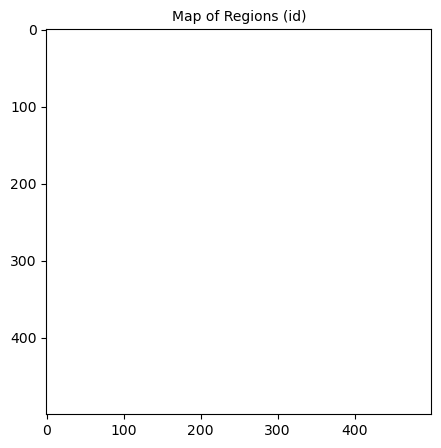

In [13]:
# Plot regions
U.plot(image='Regions', annotate='Regions', contour=True)

This statement has generated a DataFrame containing all the relevant information for each region, e.g. its area, distance, or soil moisture value. Single values can be accessed by `U.region_data.loc[8,'SM']`, for instance. Since it is a normal DataFrame, it can be saved with `U.region_data.to_csv('region_data.csv')`.

In [12]:
U.region_data

,Materials,center_mass,center_geom,area,SM,Distance_min,Distance_com,Weights,Neutrons,Contributions,Origins,Density,Regions
id,,,,,,,,,,,,,
0,40.0,"[192, 240]","[250, 250]",0.450144,0.2,1.414214,116.558998,NaN,NaN,NaN,NaN,NaN,0
1,139.0,"[444, 56]","[408, 92]",0.035816,0.695,500.617619,548.716685,NaN,NaN,NaN,NaN,NaN,1
2,10.0,"[384, 115]","[372, 128]",0.078976,0.05,349.688433,380.423448,NaN,NaN,NaN,NaN,NaN,2
3,139.0,"[128, 127]","[128, 127]",0.0729,0.695,155.56992,345.071007,NaN,NaN,NaN,NaN,NaN,3
4,100.0,"[336, 164]","[335, 164]",0.05204,0.2,191.253758,243.248844,NaN,NaN,NaN,NaN,NaN,4
5,10.0,"[289, 211]","[296, 204]",0.018404,0.05,19.849433,110.317723,NaN,NaN,NaN,NaN,NaN,5
6,100.0,"[66, 311]","[66, 311]",0.04884,0.2,259.32605,387.063302,NaN,NaN,NaN,NaN,NaN,6
7,100.0,"[312, 311]","[312, 311]",0.04884,0.2,19.849433,175.368184,NaN,NaN,NaN,NaN,NaN,7
8,60.0,"[434, 311]","[434, 311]",0.04884,0.3,261.323554,388.960152,NaN,NaN,NaN,NaN,NaN,8


It is also possible to give each region a name that can be used for annotating plots, for instance:

In [13]:
U.region_data['freetext'] = [r'$\theta=20\%$', r'wet', '     sand',
                             'also wet','grass','dry', 'meadow1', 'meadow2',
                             'pasture', 'parking', 'peatland','desert']

<AxesSubplot: title={'center': 'Map of Regions (id)\nAnnotation: Materials'}, xlabel='x (in m)', ylabel='y (in m)'>

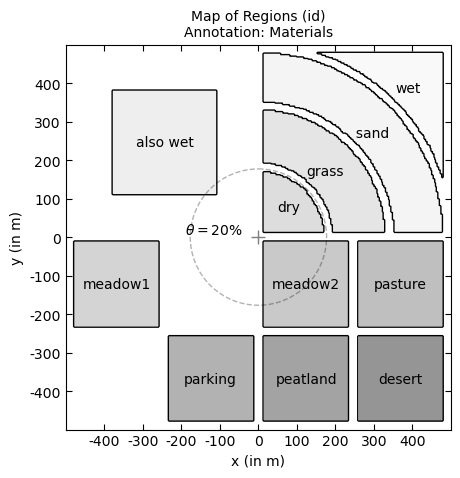

In [14]:
# Plot regions
U.plot(image='Regions', annotate='freetext', contour=True)

## 3. Basic plotting
The URANOS-specifc plotting routine is very handy to quickly make plots of the generated matrices. They can be used as soon as regions have been identified, as the arguments for annotation and contours refer to the corresponding entries in the `region_data` DataFrame.

The function `U.plot(ax, image, annotate, overlay, ...) -> ax` has the following options:
- `ax=None` - uses a given axes from an overarching figure panel, or creates a new axis and figure
- `image='SM'` - name of the matrix used for colored plotting
- `annotate=None` - attempts to annotate regions with a label given by a column name in U.region_data
- `overlay=None` - overlay 'Origins' to draw crosses of neutron origins onto the map
- `fontsize=10, title=None` - additional formatting
- `contour=False` - if True, draw the region borders on the map
- `regions=None` - list of regions to plot, e.g., `[0,4,5]`, defaults to all regions.
- `extent=500` - zoom in to a certain width/height square (500 is the whole matrix)
- `cmap='Greys'` - colorscale used for the image plot
- `cmap_scale=2` - scales the colorscale by factor 2, which is often lighter and increases readability for annotation labels.
- `x_marker=None` - x-distance in meters to draw a marker on top of the axis, e.g., to highlight a distance of a patch from the center
- `cross_alpha=0.5` - transparency of the central cross at (0,0). Set to 0 to remove it,
- `label_offset=(0,0)` - x and y offset of the labels to increase readibility over region contours
- `step_fraction=0.2` - x and y steps to use for tickmarks relative to the full extent.
- `colorbar=False` - draw a colorbar
- `axis_labels=True` - draw x and y axis labels: 'x (in m)'
- `interpolation='none'` - interpolation of the image, can be one of 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos'

Notes:
- The plotted dimensiones are always given in meters.
- The routine returns an `ax` object which can be used to make further changes to the plot. 
- If you need to save the plot, use: `ax.figure.savefig('my_plot.pdf', bbox_inches="tight")`

<AxesSubplot: title={'center': 'Map of Material code'}, xlabel='x (in m)', ylabel='y (in m)'>

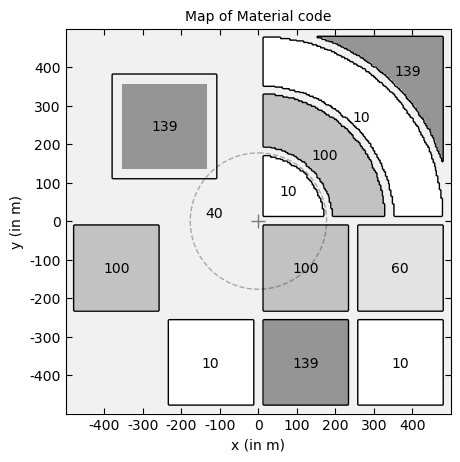

In [15]:
# Plot Material data
U.plot(image='Materials', annotate='Materials', contour=True)

<AxesSubplot: title={'center': 'Map of Soil Moisture (vol.%)'}, xlabel='x (in m)', ylabel='y (in m)'>

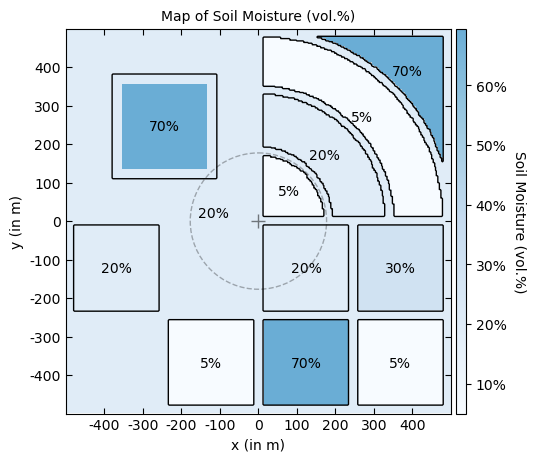

In [16]:
# Plot Soil Moisture pattern
U.plot(image='SM', annotate='SM', contour=True,
       cmap='Blues', colorbar=True)

## 4. Neutron density map
Automatically recognize the files starting with 'densityMapSelected*' and read them in as a matrix. If there are more than one file, treat them as results from parallel URANOS simulations with identical configurations. This means that the values from multiple matrices will be averaged, which greatly reduces the noise.

In [17]:
# Read in Density maps
U = U.read_density('densityMapSelected*', pad=True)

  Reading example_uranos_output/complex_fields\densityMapSelected_20220105-0507_N10000000.csv
  Reading example_uranos_output/complex_fields\densityMapSelected_20220105-0717_N10000000.csv
Imported URANOS density map as `.Density` (500 x 500).


The results will be automatically padded by 1 in order to sustain the 500x500 dimension. If the URANOS object would be initialized with size=499 at the beginning, this would not be necessary.

In [18]:
# This is how the density matrix looks like:
U.Density

array([[23., 35., 30., ..., 28., 36.,  0.],
       [26., 40., 30., ..., 24., 23.,  0.],
       [21., 16., 23., ..., 25., 29.,  0.],
       ...,
       [20., 25., 26., ..., 38., 40.,  0.],
       [36., 29., 40., ..., 32., 37.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

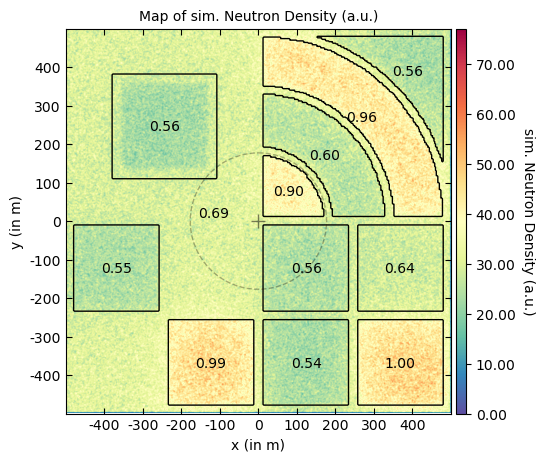

In [19]:
# Plot the density, including region contours and interpolation
ax = U.plot(image='Density', annotate='Density', contour=True, 
        cmap='Spectral_r', cmap_scale=1, colorbar=True,
       interpolation='bicubic')

## 5. Neutron Origins
Neutron origins count how many neutrons had their first soil contact at pixel (i,j) before they got detected in the central detector. The script automatically recognizes the files starting with 'detectorOrigins*' and read them in as a matrix. If there are more than one file, treat them as results from parallel URANOS simulations with identical configurations. This means that the values from multiple matrices will be averaged, which greatly reduces the noice.

In [20]:
# Read in Origin maps
U = U.read_origins('detectorOrigins*', pad=True)

  Reading example_uranos_output/complex_fields\detectorOrigins20220105-0507_N10000000.csv
  Reading example_uranos_output/complex_fields\detectorOrigins20220105-0552_N10000000.csv
  Reading example_uranos_output/complex_fields\detectorOrigins20220105-0717_N10000000.csv
Imported URANOS origins as `.Origins` (500 x 500).


<AxesSubplot: title={'center': 'Map of Soil Moisture (vol.%)\nAnnotation: sim. Contributions (%)\nOverlay: sim. Neutron Origins (x)'}, xlabel='x (in m)', ylabel='y (in m)'>

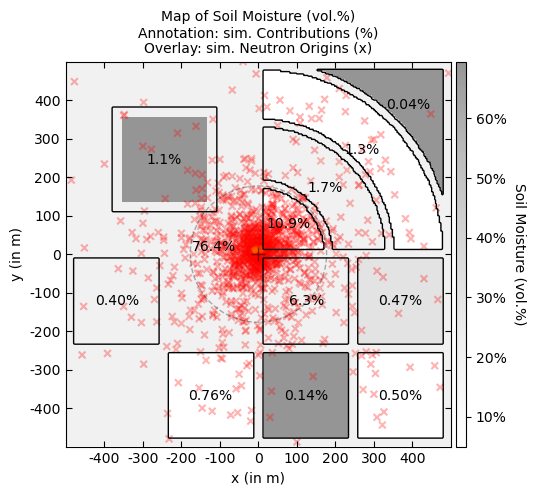

In [21]:
# Plot Origins above the SM map
U.plot(image='SM', annotate='Origins', overlay='Origins', contour=True, colorbar=True)

## 6. Histogramm data
The collected can also be shown in a number of histograms to change the perspective. Note that 'simulated contributions' are a synonym for 'Origins'.

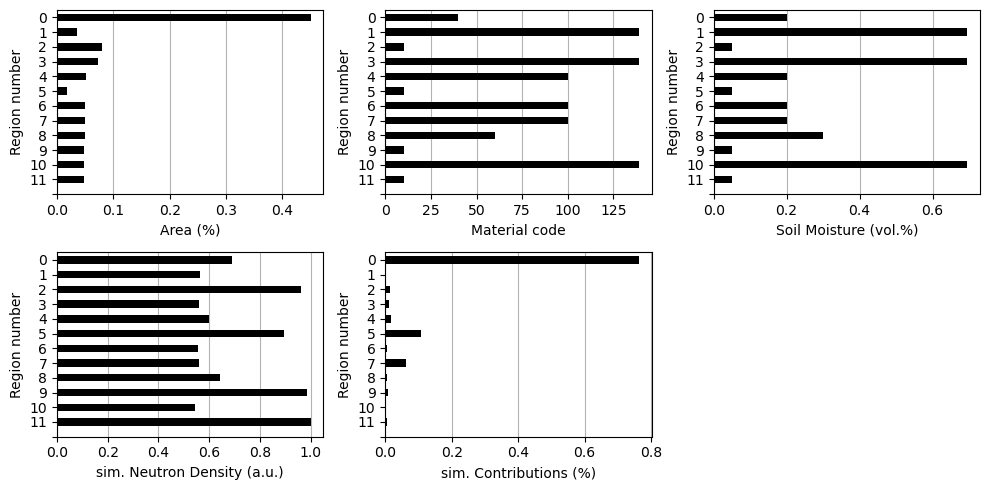

In [22]:
ax = U.histogram(var=['area', 'Materials', 'SM', 'Density', 'Origins'],
                 layout=(2,3), figsize=(10,5))

Are you looking for a specific region? Get all the available information by using the region_data DataFrame:

In [23]:
# Examine a certain region:
U.region_data.iloc[8]

Materials              60.0
center_mass      [434, 311]
center_geom      [434, 311]
area                0.04884
SM                      0.3
Distance_min     261.323554
Distance_com     388.960152
Weights                 NaN
Neutrons                NaN
Contributions           NaN
Origins            0.004686
Density            0.644526
Regions                   8
freetext            pasture
Origins_err          0.0013
Name: 8, dtype: object